# 3 - DATA VISUALISATION: PROJECT

Een analyse naar ongevallen in 2024.

## A. Initiatie

We maken een spark-sessie aan en laden de nodige libraries in.

In [2]:
# Libraries inladen
from pyspark.sql import SparkSession # Spark sessie aanmaken
import pyspark.pandas as ps # Excel-bestanden lezen
import matplotlib.pyplot as plt # Plots
import seaborn as sns # Plots
from pyspark.sql.functions import * # Bewerkingen zoals col()
from pyspark.sql.types import FloatType # Conversie naar float
import numpy as np # Arrays
import folium # Interactieve kaarten
from folium.plugins import HeatMap, MarkerCluster
from pyproj import Transformer # Coördinaten transformeren
import builtins # Python's ingebouwde functies

/usr/local/spark/python/pyspark/pandas/__init__.py:43: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
# Spark sessie aanmaken
spark = SparkSession.builder \
                    .appName("VerkeersanalyseProject") \
                    .master("local[*]") \
                    .config("spark.sql.ansi.enabled", "false") \
                    .getOrCreate()

## B. Datasets

In dit hoofdstuk worden alle datasets ingelezen gevold door een preprocessing.

### 1. Verkeersongevallen per type voertuig (2024)

In [4]:
# Dataset inlezen
# .xlsx-bestand: inlezen als Pandas-on-Spark DF (achteraf kan je omvormen naar Spark DF)
voertuig_raw = ps.read_excel('../data/Verkeersongevallen per type voertuig 2024/TF_VEHICLES_COLLISION_2024.xlsx').to_spark()

# Schema bekijken
voertuig_raw.printSchema()

/usr/local/spark/python/pyspark/pandas/namespace.py:1133: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  return pd.read_excel(


root
 |-- DT_YEAR_COLLISION: long (nullable = false)
 |-- DT_MONTH_COLLISION: long (nullable = false)
 |-- TX_MONTH_COLLISION_FR: string (nullable = false)
 |-- TX_MONTH_COLLISION_NL: string (nullable = false)
 |-- CD_DAY_NIGHT: long (nullable = false)
 |-- TX_DAY_NIGHT_FR: string (nullable = false)
 |-- TX_DAY_NIGHT_NL: string (nullable = false)
 |-- FL_WEEKEND: string (nullable = false)
 |-- CD_VEHICLE_SEGMENT_A: string (nullable = false)
 |-- TX_VEHICLE_SEGMENT_A_FR: string (nullable = false)
 |-- TX_VEHICLE_SEGMENT_A_NL: string (nullable = false)
 |-- CD_VEHICLE_SEGMENT_B: long (nullable = false)
 |-- TX_VEHICLE_SEGMENT_B_FR: string (nullable = false)
 |-- TX_VEHICLE_SEGMENT_B_NL: string (nullable = false)
 |-- MS_VEHICLE_AGE_AT_COLLISION_YR: long (nullable = false)
 |-- TX_VEHICLE_CLASS_AGE_AT_COLL_YR: string (nullable = false)
 |-- CD_FUEL_TYPE: long (nullable = false)
 |-- TX_FUEL_TYPE_FR: string (nullable = false)
 |-- TX_FUEL_TYPE_NL: string (nullable = false)
 |-- CD_CYLINDER

/usr/local/spark/python/pyspark/pandas/utils.py:1037: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [5]:
# Preprocessing
# 1. Selecteer Vlaanderen
voertuig_df = voertuig_raw.filter(col('TX_REGION_COLLISON_NL') == 'Vlaams Gewest')

# 2. Oninteressante kolommen verwijderen
# Franstalige kolommen, gewest (allemaal Vlaanderen), jaar (allemaal 2024)
kolommen_drop = ['TX_MONTH_COLLISION_FR',
                 'TX_DAY_NIGHT_FR',
                 'TX_VEHICLE_SEGMENT_A_FR',
                 'TX_VEHICLE_SEGMENT_B_FR',
                 'TX_FUEL_TYPE_FR',
                 'TX_OWNER_TYPE_FR',
                 'TX_PROV_COLLISION_FR',
                 'TX_REGION_COLLISON_FR',
                 'TX_WEATHER_FR',
                 'TX_ROAD_CONDITION_FR',
                 'TX_BUILD_UP_AREA_FR',
                 'TX_LIGHT_CONDITION_FR',
                 'TX_ROAD_TYPE_FR',
                 'TX_ACCIDENT_CLASS_FR',
                 'TX_COLLISON_TYPE_FR',
                 'TX_REGION_COLLISON_NL',
                 'DT_YEAR_COLLISION']
voertuig_df = voertuig_df.drop(*kolommen_drop) # .drop() in PySpark accepteert meerdere kolomnamen als aparte argumenten, niet als een lijst. De *-operator converteert een lijst naar individuele argumenten.

# 3. Alle stringsvalues lowercase (Belangrijk voor plots!)
string_kolommen = [c for c, t in voertuig_df.dtypes if t.startswith('string')] # Bron: Stack Overflow

for kolom in string_kolommen:
    voertuig_df = voertuig_df.withColumn(kolom, lower(col(kolom)))
    
voertuig_df.printSchema()

root
 |-- DT_MONTH_COLLISION: long (nullable = false)
 |-- TX_MONTH_COLLISION_NL: string (nullable = false)
 |-- CD_DAY_NIGHT: long (nullable = false)
 |-- TX_DAY_NIGHT_NL: string (nullable = false)
 |-- FL_WEEKEND: string (nullable = false)
 |-- CD_VEHICLE_SEGMENT_A: string (nullable = false)
 |-- TX_VEHICLE_SEGMENT_A_NL: string (nullable = false)
 |-- CD_VEHICLE_SEGMENT_B: long (nullable = false)
 |-- TX_VEHICLE_SEGMENT_B_NL: string (nullable = false)
 |-- MS_VEHICLE_AGE_AT_COLLISION_YR: long (nullable = false)
 |-- TX_VEHICLE_CLASS_AGE_AT_COLL_YR: string (nullable = false)
 |-- CD_FUEL_TYPE: long (nullable = false)
 |-- TX_FUEL_TYPE_NL: string (nullable = false)
 |-- CD_CYLINDER_CLASS_A: long (nullable = false)
 |-- TX_CYLINDER_CLASS_A: string (nullable = false)
 |-- CD_CYLINDER_CLASS_B: long (nullable = false)
 |-- TX_CYLINDER_CLASS_B: string (nullable = false)
 |-- CD_OWNER_TYPE: long (nullable = false)
 |-- TX_OWNER_TYPE_NL: string (nullable = false)
 |-- FL_VEHICLE: long (nullab

### 2. Geolocalisatie van de verkeersongevallen (2017-2024)

In [6]:
# Dataset inlezen
# .xlsx-bestand: idem dataset 1
geolocalisatie_raw = ps.read_excel('../data/Geolocalisatie van de verkeersongevallen 2017-2024/OPENDATA_MAP_2017-2024.xlsx').to_spark()

# Eerste 5 rijen bekijken
geolocalisatie_raw.printSchema()

/usr/local/spark/python/pyspark/pandas/namespace.py:1133: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  return pd.read_excel(


root
 |-- DT_YEAR_COLLISION: long (nullable = false)
 |-- DT_MONTH_COLLISION: long (nullable = false)
 |-- DT_TIME: long (nullable = false)
 |-- CD_NIS: long (nullable = false)
 |-- TX_RGN_COLLISION_FR: string (nullable = false)
 |-- TX_RGN_COLLISION_NL: string (nullable = false)
 |-- TX_PROV_COLLISION_FR: string (nullable = true)
 |-- TX_PROV_COLLISION_NL: string (nullable = true)
 |-- TX_MUNTY_COLLISION_FR: string (nullable = false)
 |-- TX_MUNTY_COLLISION_NL: string (nullable = false)
 |-- MS_X_COORD: double (nullable = true)
 |-- MS_Y_COORD: double (nullable = true)
 |-- CD_CROSSWAY: long (nullable = false)
 |-- TX_CROSSWAY_FR: string (nullable = false)
 |-- TX_CROSSWAY_NL: string (nullable = false)
 |-- CD_WEATHER: string (nullable = false)
 |-- TX_WEATHER_FR: string (nullable = false)
 |-- TX_WEATHER_NL: string (nullable = false)
 |-- CD_ROAD_CONDITION: string (nullable = false)
 |-- TX_ROAD_CONDITION_FR: string (nullable = false)
 |-- TX_ROAD_CONDITION_NL: string (nullable = fal

/usr/local/spark/python/pyspark/pandas/utils.py:1037: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [7]:
# Preprocessing
# 1. Data voor 01/01/2024 verwijderen
geolocalisatie_df = geolocalisatie_raw.filter(col('DT_YEAR_COLLISION') == 2024)

# 2. Selecteer Vlaanderen
geolocalisatie_df = geolocalisatie_df.filter(col('TX_RGN_COLLISION_NL') == 'Vlaams Gewest')

# 3. Oninteresante kolommen verwijderen
# Franstalige kolommen, gewest (allemaal Vlaanderen), jaar (allemaal 2024)
kolommen_drop = ['DT_YEAR_COLLISION',
                 'TX_RGN_COLLISION_NL',
                 'TX_RGN_COLLISION_FR',
                 'TX_PROV_COLLISION_FR',
                 'TX_MUNTY_COLLISION_FR',
                 'TX_CROSSWAY_FR',
                 'TX_WEATHER_FR',
                 'TX_ROAD_CONDITION_FR',
                 'TX_BUILD_UP_AREA_FR',
                 'TX_LIGHT_CONDITION_FR',
                 'CD_ROAD_TYPE_FR',
                 'TX_CLASS_ACCIDENTS_FR',
                 'TX_ROAD_USR_TYPE1_FR',
                 'TX_ROAD_USR_TYPE2_FR',
                 'TX_COLLISON_TYPE_FR',
                 'TX_OBSTACLES_FR']
geolocalisatie_df = geolocalisatie_df.drop(*kolommen_drop)

# 4. Alle stringsvalues lowercase
string_kolommen = [c for c, t in geolocalisatie_df.dtypes if t.startswith('string')] # Bron: Stack Overflow

for kolom in string_kolommen:
    geolocalisatie_df = geolocalisatie_df.withColumn(kolom, lower(col(kolom)))
    
geolocalisatie_df.printSchema()

root
 |-- DT_MONTH_COLLISION: long (nullable = false)
 |-- DT_TIME: long (nullable = false)
 |-- CD_NIS: long (nullable = false)
 |-- TX_PROV_COLLISION_NL: string (nullable = true)
 |-- TX_MUNTY_COLLISION_NL: string (nullable = false)
 |-- MS_X_COORD: double (nullable = true)
 |-- MS_Y_COORD: double (nullable = true)
 |-- CD_CROSSWAY: long (nullable = false)
 |-- TX_CROSSWAY_NL: string (nullable = false)
 |-- CD_WEATHER: string (nullable = false)
 |-- TX_WEATHER_NL: string (nullable = false)
 |-- CD_ROAD_CONDITION: string (nullable = false)
 |-- TX_ROAD_CONDITION_NL: string (nullable = false)
 |-- CD_BUILD_UP_AREA: long (nullable = false)
 |-- TX_BUILD_UP_AREA_NL: string (nullable = false)
 |-- CD_LIGHT_CONDITION: long (nullable = false)
 |-- TX_LIGHT_CONDITION_NL: string (nullable = false)
 |-- CD_ROAD_TYPE: long (nullable = false)
 |-- CD_ROAD_TYPE_NL: string (nullable = false)
 |-- CD_CLASS_ACCIDENTS: long (nullable = false)
 |-- TX_CLASS_ACCIDENTS_NL: string (nullable = false)
 |--

### 3. RMI Weerdata (2024)

In [8]:
# Dataset inlezen
weer_raw = spark.read.option('header', True).csv('../data/KMI/aws_1day.csv')

# Schema bekijken
weer_raw.printSchema()

root
 |-- FID: string (nullable = true)
 |-- the_geom: string (nullable = true)
 |-- code: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- precip_quantity: string (nullable = true)
 |-- temp_avg: string (nullable = true)
 |-- temp_max: string (nullable = true)
 |-- temp_min: string (nullable = true)
 |-- temp_grass_pt100_avg: string (nullable = true)
 |-- temp_soil_avg: string (nullable = true)
 |-- temp_soil_avg_5cm: string (nullable = true)
 |-- temp_soil_avg_10cm: string (nullable = true)
 |-- temp_soil_avg_20cm: string (nullable = true)
 |-- temp_soil_avg_50cm: string (nullable = true)
 |-- wind_speed_10m: string (nullable = true)
 |-- wind_speed_avg_30m: string (nullable = true)
 |-- wind_gusts_speed: string (nullable = true)
 |-- humidity_rel_shelter_avg: string (nullable = true)
 |-- pressure: string (nullable = true)
 |-- sun_duration: string (nullable = true)
 |-- short_wave_from_sky_avg: string (nullable = true)
 |-- sun_int_avg: string (nullable = true

In [9]:
# Preprocessing
# 1. Kolom timestamp omzetten van string naar datatime
weer_df = weer_raw.withColumn('timestamp', to_timestamp(col('timestamp'), 'yyyy-MM-dd\'T\'HH:mm:ss'))

# 2. Tabel 'maand' toevoegen
weer_df = weer_df.withColumn('maand', month(col('timestamp')))

# 2. Specifieke kolommen omvormen naar float
float_kolommen = [
    'precip_quantity', 
    'temp_avg', 
    'temp_max',
    'temp_min',
    'temp_grass_pt100_avg',
    'temp_soil_avg',
    'temp_soil_avg_5cm',
    'temp_soil_avg_10cm',
    'temp_soil_avg_20cm',
    'temp_soil_avg_50cm',
    'wind_speed_10m',
    'wind_speed_avg_30m',
    'wind_gusts_speed',
    'humidity_rel_shelter_avg',
    'pressure',
    'sun_duration',
    'short_wave_from_sky_avg',
    'sun_int_avg'
]

for kolom in float_kolommen:
    weer_df = weer_df.withColumn(kolom, col(kolom).cast(FloatType()))


# 3. Kolom provincie toevoegen (a.d.h.v. code weerstation)
# Dictionary: code - provincie (BRON: RMI aws_station documentatie)
code_provincies = {
    '10101002': 'provincie west-vlaanderen', # De Haan
    '6477': 'provincie limburg', # Diepenbeek
    '6414': 'provincie west-vlaanderen', # Beitem
    '6438': 'provincie antwerpen', # Stabroek
    '6464': 'provincie antwerpen', # Retie
    '6447': 'Brussel', # Uccle (Wordt later verwijderd!)
    '6434': 'provincie oost-vlaanderen', # Melle
    '6439': 'provincie antwerpen', # Sint-Katelijne-Waver
    '6418': 'provincie west-vlaanderen', # Zeebrugge
    }

# When-otherwise constructie voor provincie
# when() is de start van de chain, .when() bouwt verder.
# Je kunt niet beginnen met een lege expressie, dus moet je het eerste item apart behandelen.
provincie_expr = when(col('code') == list(code_provincies.keys())[0], 
                      list(code_provincies.values())[0])
for code, provincie in list(code_provincies.items())[1:]:
    provincie_expr = provincie_expr.when(col('code') == code, provincie)
weer_df = weer_df.withColumn('provincie', provincie_expr)

# 4. Coördinaten in twee aparte kolommen (nu: 'POINT (lat long)')
# Verwijder 'POINT (' en ')'
weer_df = weer_df.withColumn('the_geom', # Resultaat: 'lat long'
    regexp_replace(col('the_geom'), r'POINT \(|\)', '')) # regexp_replace(kolom die je wil bewerken, patroon die je wil vervangen, waarmee je die wil vervangen)

weer_df = weer_df.withColumn('latitude', 
    split(col('the_geom'), ' ').getItem(0).cast(FloatType())) # Split 'lat long' en neem eerste item + verander in float

weer_df = weer_df.withColumn('longitude', 
    split(col('the_geom'), ' ').getItem(1).cast(FloatType())) # Split 'lat long' en neem tweede item + verander in float

# 5. Verwijder Brussel
weer_df = weer_df.filter(col('code') != '6447')

# 6. Oninteressante kolommen verwijderen
# Code weerstation, FID, qc_flags, coördinaten (origineel)
kolommen_drop = ['code', 'FID', 'qc_flags', 'the_geom']
weer_df = weer_df.drop(*kolommen_drop)

# Schema bekijken
weer_df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- precip_quantity: float (nullable = true)
 |-- temp_avg: float (nullable = true)
 |-- temp_max: float (nullable = true)
 |-- temp_min: float (nullable = true)
 |-- temp_grass_pt100_avg: float (nullable = true)
 |-- temp_soil_avg: float (nullable = true)
 |-- temp_soil_avg_5cm: float (nullable = true)
 |-- temp_soil_avg_10cm: float (nullable = true)
 |-- temp_soil_avg_20cm: float (nullable = true)
 |-- temp_soil_avg_50cm: float (nullable = true)
 |-- wind_speed_10m: float (nullable = true)
 |-- wind_speed_avg_30m: float (nullable = true)
 |-- wind_gusts_speed: float (nullable = true)
 |-- humidity_rel_shelter_avg: float (nullable = true)
 |-- pressure: float (nullable = true)
 |-- sun_duration: float (nullable = true)
 |-- short_wave_from_sky_avg: float (nullable = true)
 |-- sun_int_avg: float (nullable = true)
 |-- maand: integer (nullable = true)
 |-- provincie: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- l

## C. Visualisaties

### 1. Poging tot merge dataset 1 en 2 - MISLUKT

Ik was initieel van plan om de twee datasets van Statbel te combineren tot 1 grote dataframe. Maar beide datasets bevatten geen unieke combinatie, waardoor een accurate merge onmogelijk is. Dataset 1 mist gedetailleerde informatie over de locatie (enkel provincie is gegeven) en beide datasets missen gedetailleerde informatie over de dag (enkel maand en jaar zijn gegeven).

Let op:
- **Dataset 1:** 1 rij = 1 voertuig betrokken bij een accident
- **Dataset 2:** 1 rij = 1 accident

In [10]:
# 1. Kolom dag/nacht toevoegen aan geolocalisatie_df
# Regel: 06:00 t/m 21:59 is dag (1), de rest is nacht (2)
geolocalisatie_test = geolocalisatie_df.withColumn('CD_DAY_NIGHT', when((col('DT_TIME') >= 6) & (col('DT_TIME') <= 21), 1).otherwise(2))

# 2. Kolom accident_id toevoegen aan geolocalisatie_df
geolocalisatie_test = geolocalisatie_test.withColumn('ACCIDENT_ID', monotonically_increasing_id() + 1)

# 3. Join datasets
# Left join: behoud alle voertuigen, ook als geen match bestaat

# Kolommen in voertuig_df
left_keys = [
    'DT_MONTH_COLLISION',     # Maand
    'TX_PROV_COLLISION_NL',   # Provincie
    'TX_WEATHER_NL',          # Weer
    'TX_ROAD_CONDITION_NL',   # Wegconditie
    'TX_BUILD_UP_AREA_NL',    # Gebied
    'TX_LIGHT_CONDITION_NL',  # Lichtconditie
    'TX_ROAD_TYPE_NL',        # Type weg
    'TX_ACCIDENT_CLASS_NL',   # Ongevalernst
    'TX_COLLISON_TYPE_NL',    # Type ongeval
    'CD_DAY_NIGHT'            # Dag/nacht 
]

# Kolommen in geolocalisatie_test
right_keys = [
    'DT_MONTH_COLLISION',
    'TX_PROV_COLLISION_NL',
    'TX_WEATHER_NL',
    'TX_ROAD_CONDITION_NL',
    'TX_BUILD_UP_AREA_NL',
    'TX_LIGHT_CONDITION_NL',
    'CD_ROAD_TYPE_NL',
    'TX_CLASS_ACCIDENTS_NL',
    'TX_COLLISION_TYPE_NL',
    'CD_DAY_NIGHT'
]
# Join conditie maken
join_condition = (
    (voertuig_df['DT_MONTH_COLLISION'] == geolocalisatie_test['DT_MONTH_COLLISION']) &
    (voertuig_df['TX_PROV_COLLISION_NL'] == geolocalisatie_test['TX_PROV_COLLISION_NL']) &
    (voertuig_df['TX_WEATHER_NL'] == geolocalisatie_test['TX_WEATHER_NL']) &
    (voertuig_df['TX_ROAD_CONDITION_NL'] == geolocalisatie_test['TX_ROAD_CONDITION_NL']) &
    (voertuig_df['TX_BUILD_UP_AREA_NL'] == geolocalisatie_test['TX_BUILD_UP_AREA_NL']) &
    (voertuig_df['TX_LIGHT_CONDITION_NL'] == geolocalisatie_test['TX_LIGHT_CONDITION_NL']) &
    (voertuig_df['TX_ROAD_TYPE_NL'] == geolocalisatie_test['CD_ROAD_TYPE_NL']) &
    (voertuig_df['TX_ACCIDENT_CLASS_NL'] == geolocalisatie_test['TX_CLASS_ACCIDENTS_NL']) &
    (voertuig_df['TX_COLLISON_TYPE_NL'] == geolocalisatie_test['TX_COLLISION_TYPE_NL']) &
    (voertuig_df['CD_DAY_NIGHT'] == geolocalisatie_test['CD_DAY_NIGHT'])
)

voertuig_final = voertuig_df.join(geolocalisatie_test, join_condition, 'left')

# Statistieken printen
print(f"Lengte voertuig_df: {voertuig_df.count()}")
print(f"Lengte geolocalisatie_df: {geolocalisatie_test.count()}")
print(f"Lengte voertuig_final: {voertuig_final.count()}")

Lengte voertuig_df: 26467
Lengte geolocalisatie_df: 22185
Lengte voertuig_final: 192069


### 2. Geografische analyse

#### a. Heatmap

In [11]:
## Dataset 2 + 3
# 1. Filter geldige coördinaten en neem een sample (max 10000)
geo_sample = geolocalisatie_df.filter(
    (col('MS_X_COORD').isNotNull()) & 
    (col('MS_Y_COORD').isNotNull())) \
    .select('MS_X_COORD', 'MS_Y_COORD') \
    .limit(10000) \
    .collect()

# 2. Transformeer de coordinaten (Lambert 72 naar EPSG 4326)
transformer = Transformer.from_crs("EPSG:31370", "EPSG:4326", always_xy=True)
coords_transformed = []
for row in geo_sample:
        lon, lat = transformer.transform(row['MS_X_COORD'], row['MS_Y_COORD'])
        if 49 < lat < 52 and 2 < lon < 6:  # Binnen België
            coords_transformed.append([lat, lon])

# 3. Plot - Stijl m.b.v. Claude
center_lat = builtins.sum([c[0] for c in coords_transformed]) / len(coords_transformed)
center_lon = builtins.sum([c[1] for c in coords_transformed]) / len(coords_transformed)
    
m1 = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles='OpenStreetMap')
HeatMap(coords_transformed, radius=15, blur=25, max_zoom=13).add_to(m1)
    
# Weerstations
weer_stations = weer_df.select('latitude', 'longitude', 'provincie').distinct().collect()
for station in weer_stations:
    folium.Marker(
        location=[station['latitude'], station['longitude']],
        popup=f"Weerstation: {station['provincie']}",
        icon=folium.Icon(color='blue', icon='cloud')) \
        .add_to(m1)
m1

#### b. Provincie-vergelijkingen

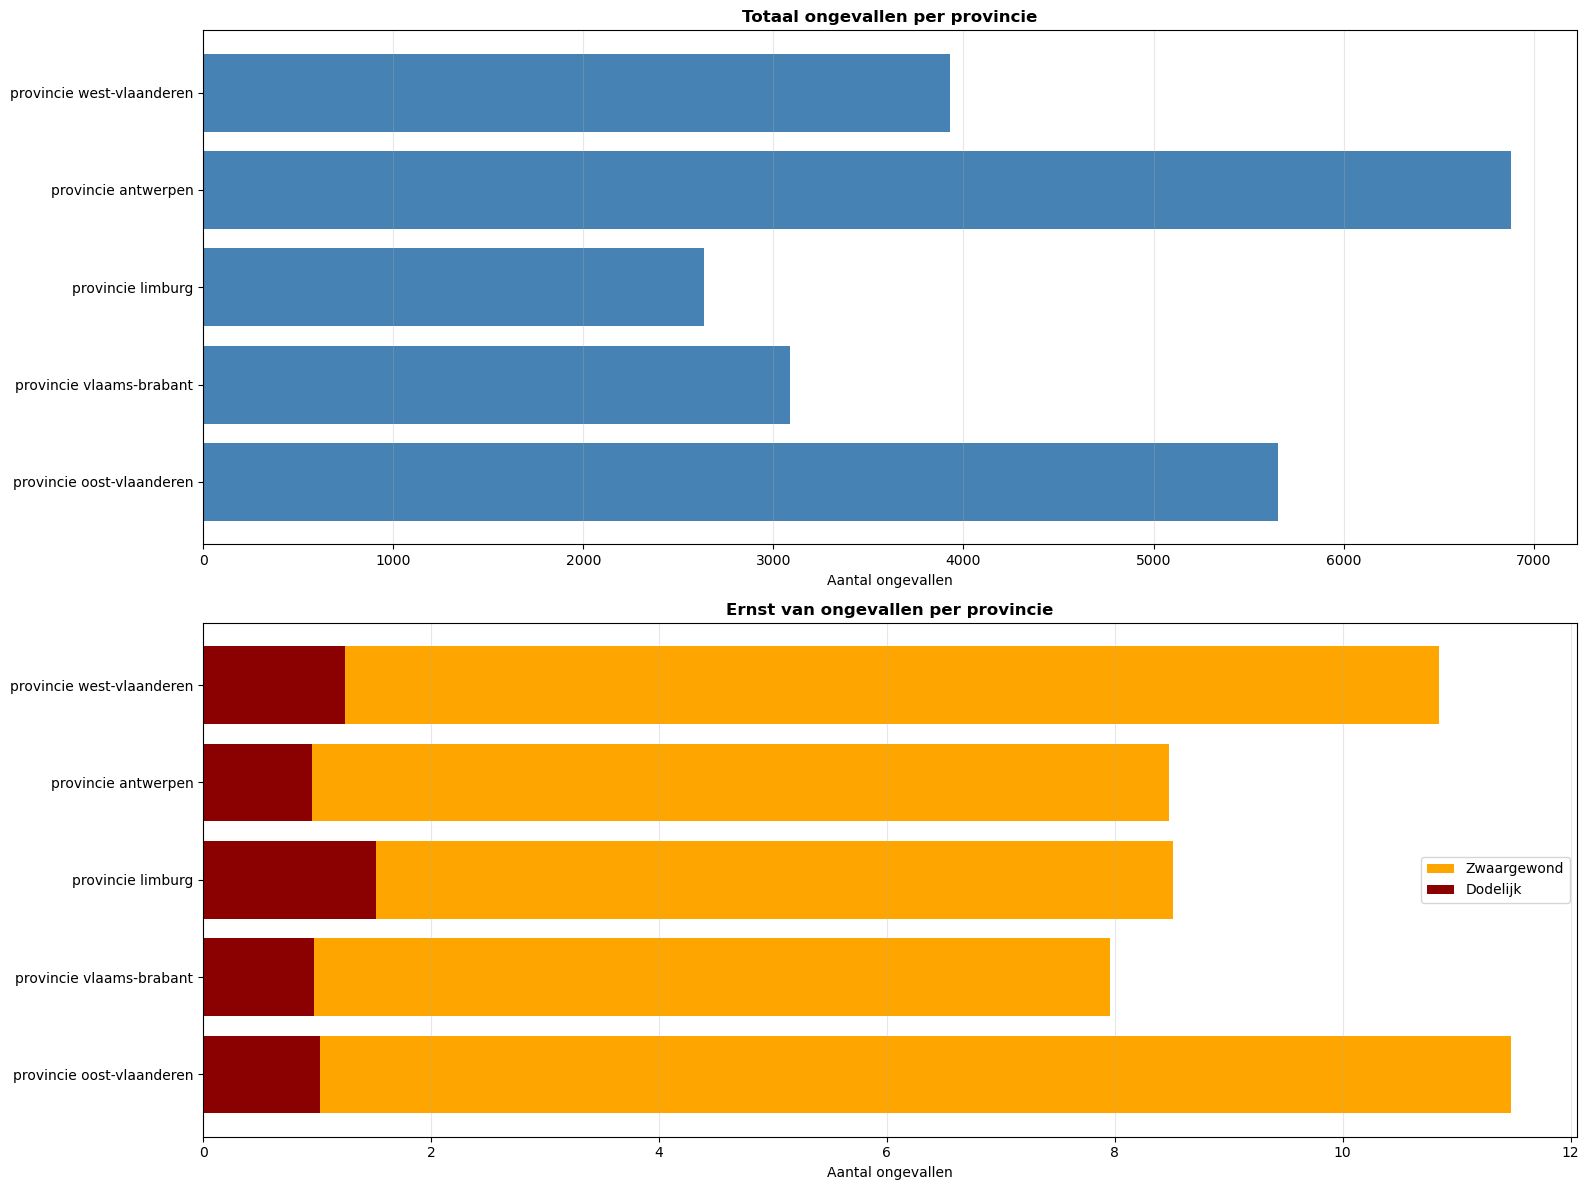

In [12]:
## Dataset 2
# 1. Ongevallen per provincie ophalen + aantal zware/dodelijke ongevallen
provincie_ongeval = geolocalisatie_df.groupBy('TX_PROV_COLLISION_NL') \
    .agg(count('*').alias('totaal_ongevallen'),
         (sum(when(col('TX_CLASS_ACCIDENTS_NL').contains("dode"), 1).otherwise(0))/count('*')*100).alias('dodelijk'), # Als 'dode' in kolom zit, geef 1 anders 0 -> Bereken som (= aantal dodelijk) -> Deel door aantal ongevallen -> Maal 100 -> Geef alias => RESULTAAT: percentage dodelijk
         (sum(when(col('TX_CLASS_ACCIDENTS_NL').contains("zwaar"), 1).otherwise(0))/count('*')*100).alias('zwaargewond')) \
    .collect()

# 2. Data ophalen voor plots
provincies = [row['TX_PROV_COLLISION_NL'] for row in provincie_ongeval]
totaal = [row['totaal_ongevallen'] for row in provincie_ongeval]
dodelijk = [row['dodelijk'] for row in provincie_ongeval]
zwaargewond = [row['zwaargewond'] for row in provincie_ongeval]

# 3. Plots - Stijl m.b.v. Claude
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Subplot 1: Aantal ongevallen per provincie
axes[0].barh(provincies, totaal, color='steelblue')
axes[0].set_xlabel('Aantal ongevallen')
axes[0].set_title('Totaal ongevallen per provincie', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Subplot 2: Ernst
axes[1].barh(provincies, zwaargewond, left=dodelijk, label='Zwaargewond', color='orange')
axes[1].barh(provincies, dodelijk, label='Dodelijk', color='darkred')
axes[1].set_xlabel('Aantal ongevallen')
axes[1].set_title('Ernst van ongevallen per provincie', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Antwerpen had in 2024 de meeste verkeersongevallen, Limburg de minste. Opvallend is dat Limburg toch een 0,5% hoger aandeel dodelijke ongevallen heeft, ondanks het lagere totaal. Het percentage zwaargewonden is gelijk.

#### c. Interactieve kaart: dodelijke ongevallen

In [13]:
## Dataset 2 + 3
# 1. Filter dodelijke ongevallen
dodelijke_ongevallen = geolocalisatie_df.filter(
    (col('TX_CLASS_ACCIDENTS_NL').contains("dode")) &
    (col('MS_X_COORD').isNotNull()) & 
    (col('MS_Y_COORD').isNotNull())) \
    .select('MS_X_COORD', 'MS_Y_COORD', 'TX_MUNTY_COLLISION_NL', 'TX_WEATHER_NL', 'DT_MONTH_COLLISION') \
    .collect()

# 2. Transformeer coördinaten
#transformer = Transformer.from_crs("EPSG:31370", "EPSG:4326", always_xy=True)
coords_transformed = []
for row in dodelijke_ongevallen:
    lon, lat = transformer.transform(row['MS_X_COORD'], row['MS_Y_COORD'])
    if 49 < lat < 52 and 2 < lon < 6:
        coords_transformed.append({
            'lat': lat,
            'lon': lon,
            'gemeente': row['TX_MUNTY_COLLISION_NL'],
            'weer': row['TX_WEATHER_NL'],
            'maand': row['DT_MONTH_COLLISION']
        })

# 3. Plot - Stijl m.b.v. Claude
center_lat = builtins.sum([c['lat'] for c in coords_transformed]) / len(coords_transformed)
center_lon = builtins.sum([c['lon'] for c in coords_transformed]) / len(coords_transformed)
    
m2 = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles='CartoDB positron') 
marker_cluster = MarkerCluster().add_to(m2)
for ongeval in coords_transformed:
    folium.Marker(
        location=[ongeval['lat'], ongeval['lon']],
        popup=f"<b>Dodelijk Ongeval</b><br>"
              f"Gemeente: {ongeval['gemeente']}<br>"
              f"Weer: {ongeval['weer']}<br>"
              f"Maand: {ongeval['maand']}",
        icon=folium.Icon(color='red', icon='exclamation-triangle', prefix='fa')) \
        .add_to(marker_cluster)
    
# Weerstations
weer_stations = weer_df.select('latitude', 'longitude', 'provincie').distinct().collect()
for station in weer_stations:
    folium.Marker(
        location=[station['latitude'], station['longitude']],
        popup=f"Weerstation: {station['provincie']}",
        icon=folium.Icon(color='blue', icon='cloud')) \
        .add_to(m2)

m2

### 3. Tijdsanalyse

#### a. Ongevallen per uur van de dag

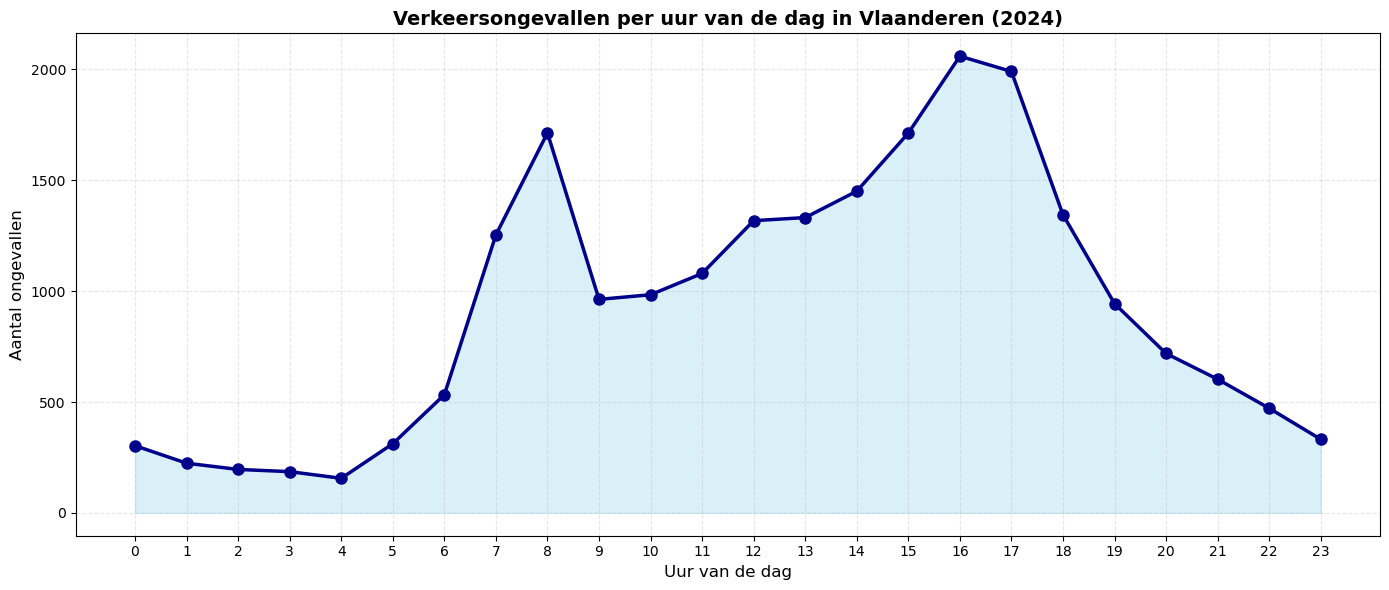

In [14]:
## Dataset 2
# 1. Aantal ongevallen per uur ophalen
ongevallen_uur = geolocalisatie_df.filter(col('DT_TIME').isNotNull()) \
    .groupBy('DT_TIME') \
    .agg(count('*').alias('aantal_ongevallen')) \
    .orderBy('DT_TIME') \
    .collect()

# 2. Data ophalen voor plots
uren = [row['DT_TIME'] for row in ongevallen_uur]
aantal_per_uur = [row['aantal_ongevallen'] for row in ongevallen_uur]

# 3. Plot - Stijl m.b.v. Claude
plt.figure(figsize=(14, 6))
plt.plot(uren, aantal_per_uur, marker='o', linewidth=2.5, markersize=8, color='darkblue')
plt.fill_between(uren, aantal_per_uur, alpha=0.3, color='skyblue')
plt.xlabel('Uur van de dag', fontsize=12)
plt.ylabel('Aantal ongevallen', fontsize=12)
plt.title('Verkeersongevallen per uur van de dag in Vlaanderen (2024)', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


Deze plot bevestigt dat de meeste ongevallen zich voordoen tijdens de spitsuren.

#### b. Dag/nacht vergelijking per ongevalernst

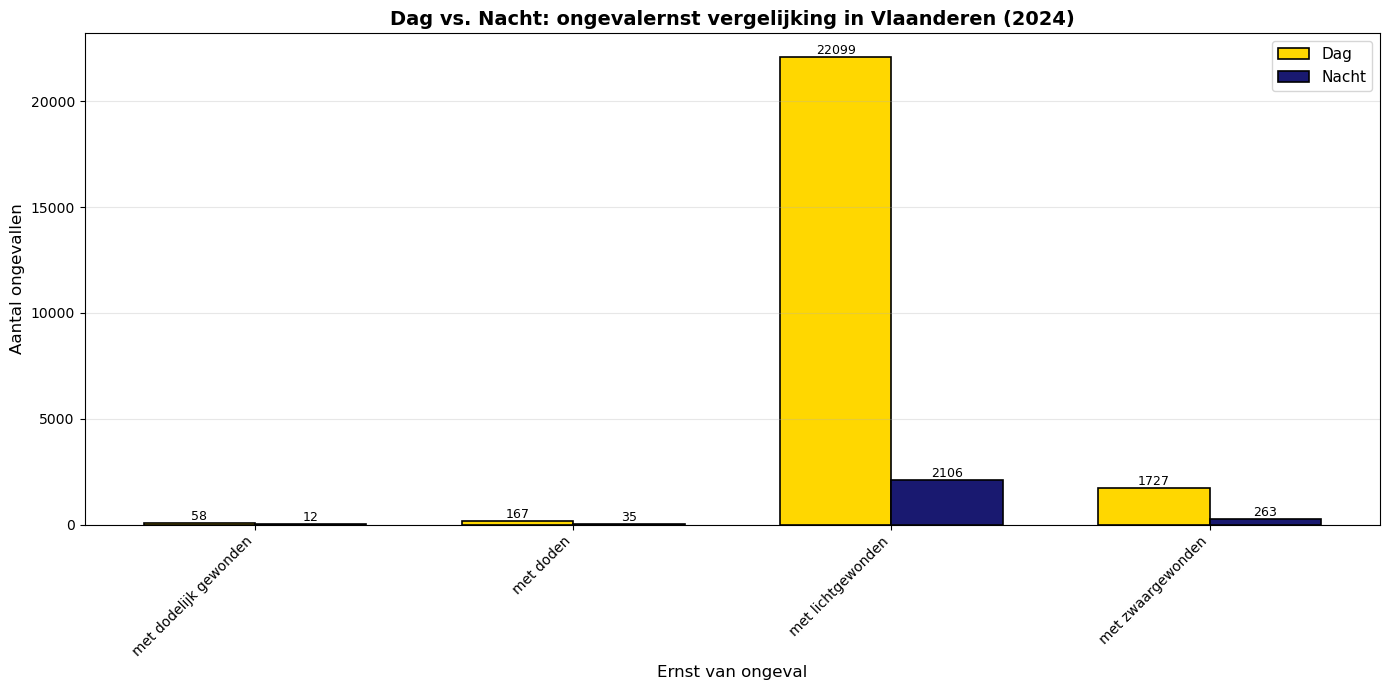

In [15]:
## Dataset 1
# 1. Haal dag/nacht data op
dag_nacht_ernst = voertuig_df.filter(col('TX_DAY_NIGHT_NL').isNotNull() & col('TX_ACCIDENT_CLASS_NL').isNotNull()) \
    .groupBy('TX_DAY_NIGHT_NL', 'TX_ACCIDENT_CLASS_NL') \
    .agg(count('*').alias('aantal')) \
    .collect()

# 2. Data ophalen voor plots
ernst_types = sorted(list(set([row['TX_ACCIDENT_CLASS_NL'] for row in dag_nacht_ernst])))
dag_data = [0] * len(ernst_types)
nacht_data = [0] * len(ernst_types)

for row in dag_nacht_ernst:
    ernst_idx = ernst_types.index(row['TX_ACCIDENT_CLASS_NL'])
    if row['TX_DAY_NIGHT_NL'] == 'dag':
        dag_data[ernst_idx] = row['aantal']
    else:  # 'nacht' of andere waarde
        nacht_data[ernst_idx] = row['aantal']

# 3. Plot - Stijl m.b.v. Claude
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(ernst_types))
width = 0.35

bars1 = ax.bar(x - width/2, dag_data, width, label='Dag', color='gold', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, nacht_data, width, label='Nacht', color='midnightblue', edgecolor='black', linewidth=1.2)

# Voeg waarden toe op bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Ernst van ongeval', fontsize=12)
ax.set_ylabel('Aantal ongevallen', fontsize=12)
ax.set_title('Dag vs. Nacht: ongevalernst vergelijking in Vlaanderen (2024)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ernst_types, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### c. Weekdag vs weekend

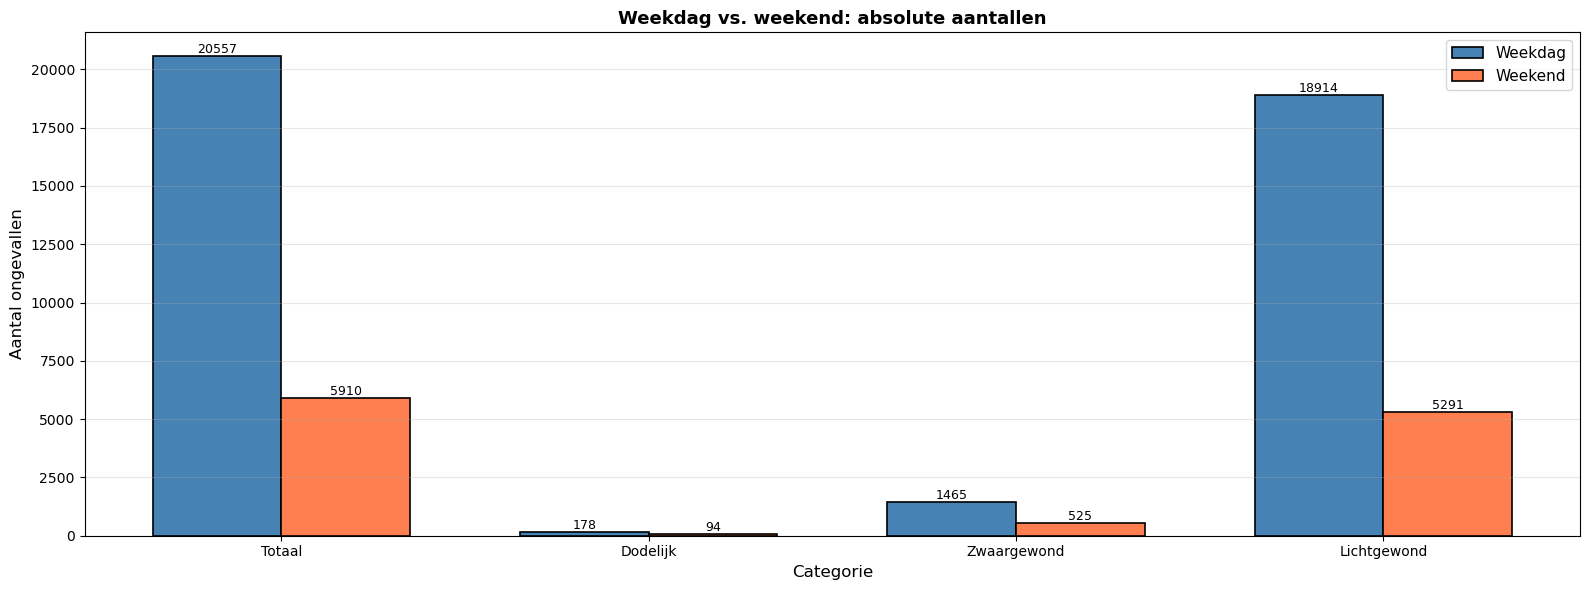

In [16]:
## Dataset
# 1. Neem weekend data op
voertuig_weekend = voertuig_df.filter(col('FL_WEEKEND').isNotNull() & col('TX_ACCIDENT_CLASS_NL').isNotNull()) \
    .groupBy('FL_WEEKEND') \
    .agg(count('*').alias('totaal_ongevallen'),
         sum(when(col('TX_ACCIDENT_CLASS_NL').contains('dode'), 1).otherwise(0)).alias('dodelijk'),
         sum(when(col('TX_ACCIDENT_CLASS_NL').contains('zwaargewond'), 1).otherwise(0)).alias('zwaargewond'),
         sum(when(col('TX_ACCIDENT_CLASS_NL').contains('lichtgewond'), 1).otherwise(0)).alias('lichtgewond')) \
    .collect()

# 2. Data organiseren
categorieën = ['Totaal', 'Dodelijk', 'Zwaargewond', 'Lichtgewond']
weekdag_data = [0, 0, 0, 0]
weekend_data = [0, 0, 0, 0]

for row in voertuig_weekend:
    if row['FL_WEEKEND'] == 'n':  # Weekdag
        weekdag_data = [row['totaal_ongevallen'], row['dodelijk'], 
                        row['zwaargewond'], row['lichtgewond']]
    else:  # Weekend ('Y')
        weekend_data = [row['totaal_ongevallen'], row['dodelijk'], 
                       row['zwaargewond'], row['lichtgewond']]

# 3. Plot - Stijl m.b.v. Claude
fig, ax1 = plt.subplots(figsize=(16, 6))

x = np.arange(len(categorieën))
width = 0.35

bars1 = ax1.bar(x - width/2, weekdag_data, width, label='Weekdag', 
                color='steelblue', edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, weekend_data, width, label='Weekend', 
                color='coral', edgecolor='black', linewidth=1.2)

# Voeg waarden toe
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)

ax1.set_xlabel('Categorie', fontsize=12)
ax1.set_ylabel('Aantal ongevallen', fontsize=12)
ax1.set_title('Weekdag vs. weekend: absolute aantallen', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categorieën)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

De meeste ongevallen deden zich tijdens de weekdagen voor.

### 4. Weeranalyse

#### a. Ongevallen per maand vs. weerfactoren

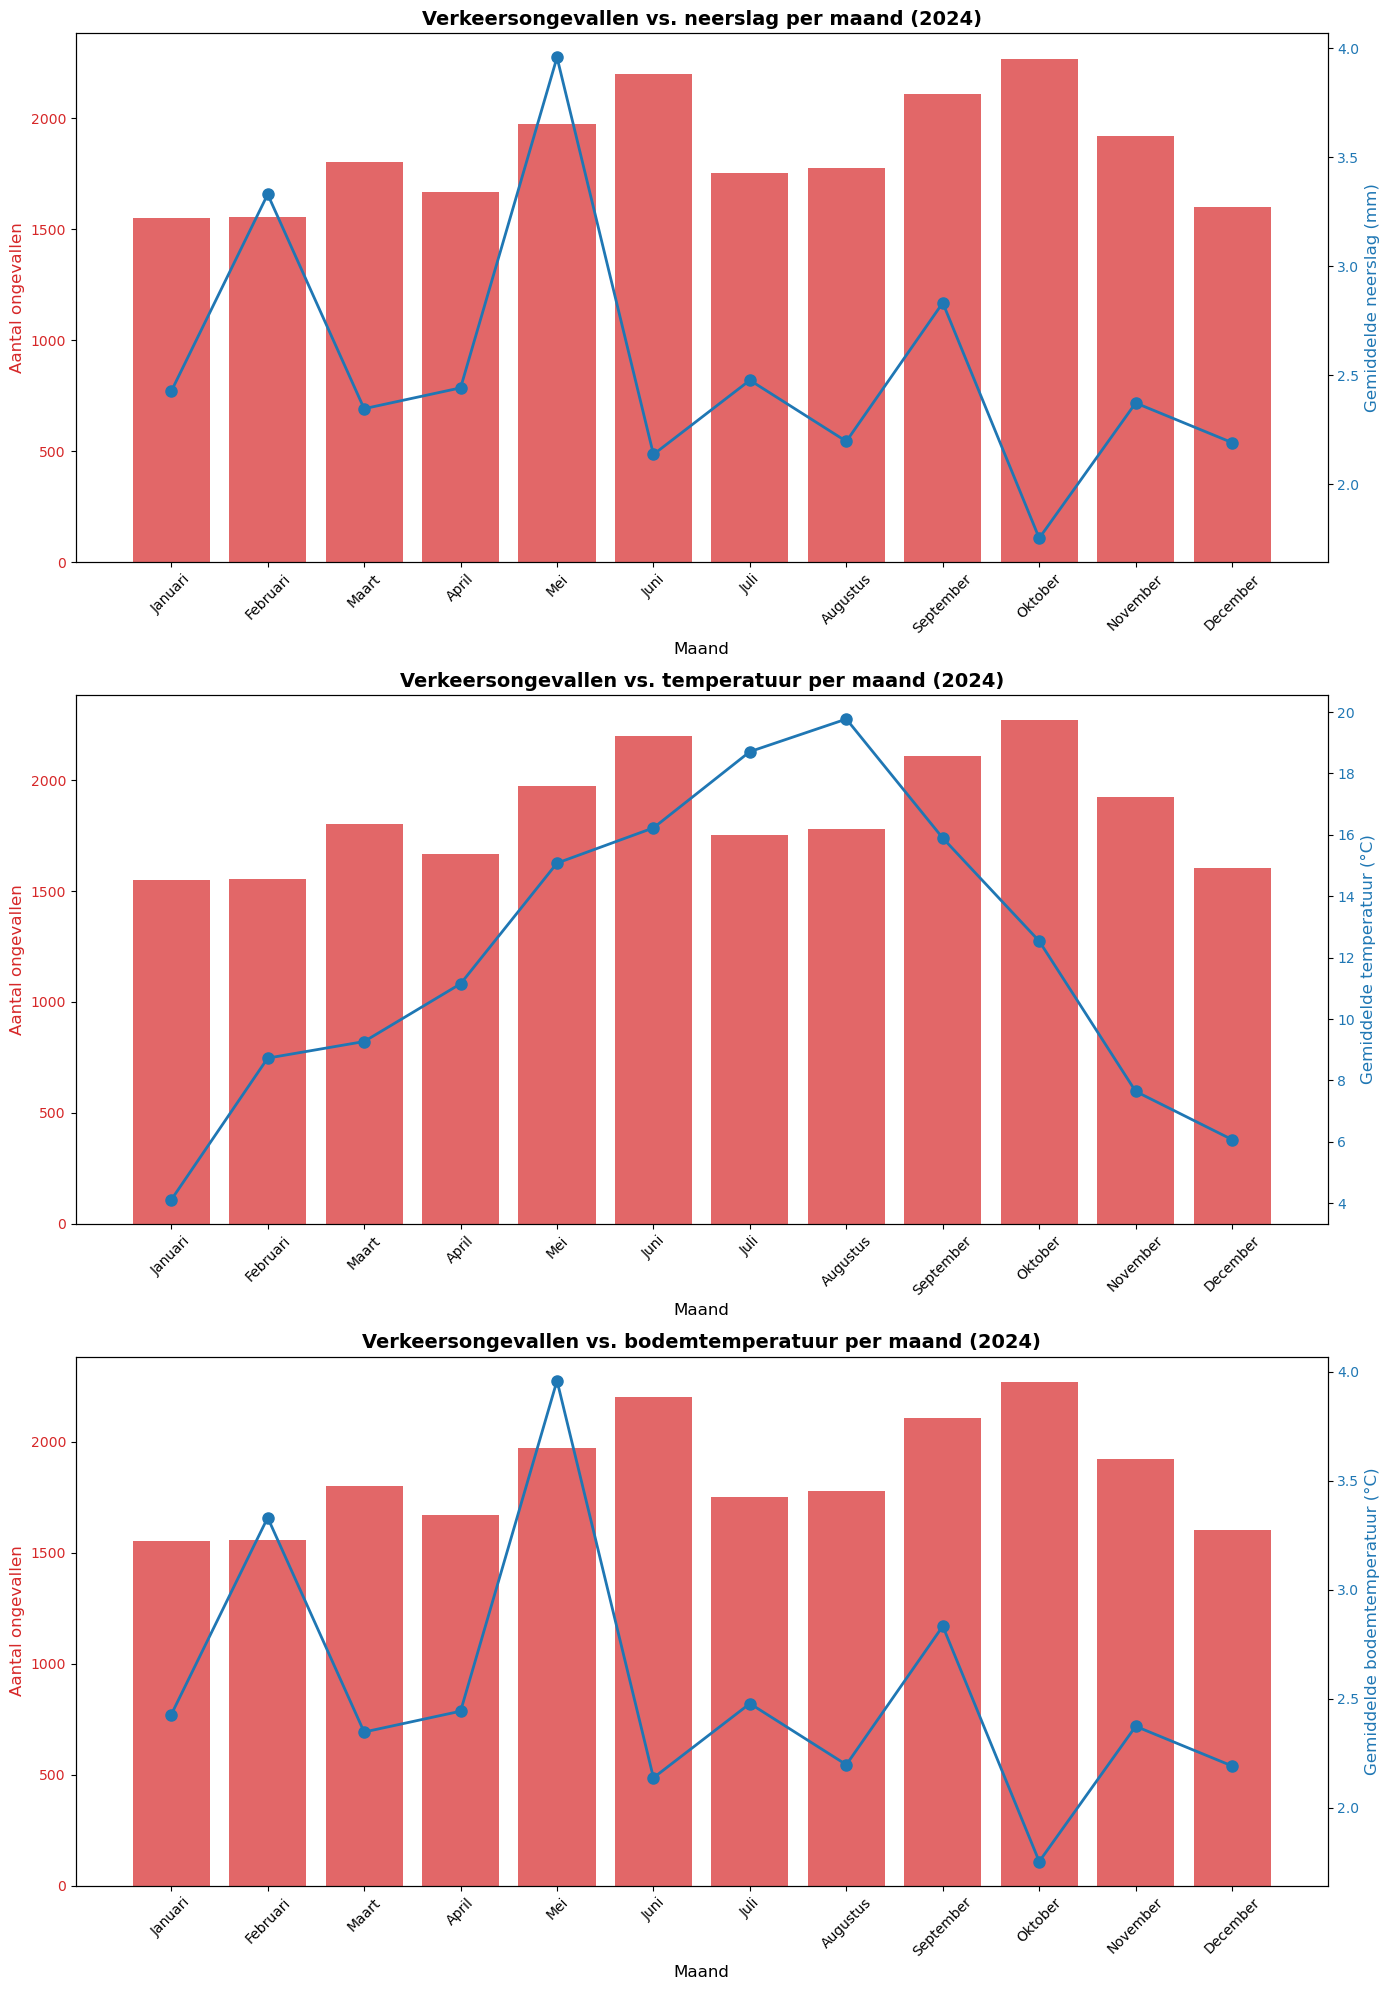

In [17]:
## Dataset 2 + 3
# 1. Ongevallen per maand ophalen
ongevallen_per_maand = geolocalisatie_df.groupBy('DT_MONTH_COLLISION') \
    .agg(count('*').alias('aantal_ongevallen')) \
    .orderBy('DT_MONTH_COLLISION') \
    .collect()

# 2. Neerslag per maand ophalen
neerslag_per_maand = weer_df.groupBy('maand') \
    .agg(avg('precip_quantity').alias('gem_neerslag'),
         avg('temp_avg').alias('gem_temp'),
         avg('temp_soil_avg').alias('gem_temp_bodem')) \
    .orderBy('maand') \
    .collect()


# 3. Extract data
maanden = ['Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December']
aantal_ongevallen = [row['aantal_ongevallen'] for row in ongevallen_per_maand]
gem_neerslag = [row['gem_neerslag'] for row in neerslag_per_maand]
gem_temp = [row['gem_temp'] for row in neerslag_per_maand]
gem_temp_bodem = [row['gem_temp_bodem'] for row in neerslag_per_maand]

# 4. Plot - Stijl m.b.v. Claude
fig, axes = plt.subplots(3,1, figsize=(14, 20))

#Subplot 1: ongeval vs neerslag
# Ongevallen (y-as links)
color = 'tab:red'
axes[0].set_xlabel('Maand', fontsize=12)
axes[0].set_ylabel('Aantal ongevallen', color=color, fontsize=12)
axes[0].bar(maanden, aantal_ongevallen, color=color, alpha=0.7, label='Ongevallen')
axes[0].tick_params(axis='y', labelcolor=color)
axes[0].tick_params(axis='x', rotation=45)

# Neerslag (rechter y-as)
ax1 = axes[0].twinx() # Als je x-as wil delen
color = 'tab:blue'
ax1.set_ylabel('Gemiddelde neerslag (mm)', color=color, fontsize=12)
ax1.plot(maanden, gem_neerslag, color=color, marker='o', linewidth=2, 
         markersize=8, label='Neerslag')
ax1.tick_params(axis='y', labelcolor=color)
axes[0].set_title('Verkeersongevallen vs. neerslag per maand (2024)', fontsize=14, fontweight='bold')

#Subplot 2: ongeval vs temperatuur
# Ongevallen (y-as links)
color = 'tab:red'
axes[1].set_xlabel('Maand', fontsize=12)
axes[1].set_ylabel('Aantal ongevallen', color=color, fontsize=12)
axes[1].bar(maanden, aantal_ongevallen, color=color, alpha=0.7, label='Ongevallen')
axes[1].tick_params(axis='y', labelcolor=color)
axes[1].tick_params(axis='x', rotation=45)

# Temperatuur (rechter y-as)
ax2 = axes[1].twinx() # Als je x-as wil delen
color = 'tab:blue'
ax2.set_ylabel('Gemiddelde temperatuur (°C)', color=color, fontsize=12)
ax2.plot(maanden, gem_temp, color=color, marker='o', linewidth=2, 
         markersize=8, label='Temperatuur')
ax2.tick_params(axis='y', labelcolor=color)
axes[1].set_title('Verkeersongevallen vs. temperatuur per maand (2024)', fontsize=14, fontweight='bold')

#Subplot 3: ongeval vs bodemtemperatuur
# Ongevallen (y-as links)
color = 'tab:red'
axes[2].set_xlabel('Maand', fontsize=12)
axes[2].set_ylabel('Aantal ongevallen', color=color, fontsize=12)
axes[2].bar(maanden, aantal_ongevallen, color=color, alpha=0.7, label='Ongevallen')
axes[2].tick_params(axis='y', labelcolor=color)
axes[2].tick_params(axis='x', rotation=45)

# Neerslag (rechter y-as)
ax3 = axes[2].twinx() # Als je x-as wil delen
color = 'tab:blue'
ax3.set_ylabel('Gemiddelde bodemtemperatuur (°C)', color=color, fontsize=12)
ax3.plot(maanden, gem_neerslag, color=color, marker='o', linewidth=2, 
         markersize=8, label='Bodemtemperatuur')
ax3.tick_params(axis='y', labelcolor=color)
axes[2].set_title('Verkeersongevallen vs. bodemtemperatuur per maand (2024)', fontsize=14, fontweight='bold')

fig.tight_layout()
plt.show()

#### b. Weeromstandigheden vs. ongevalernst

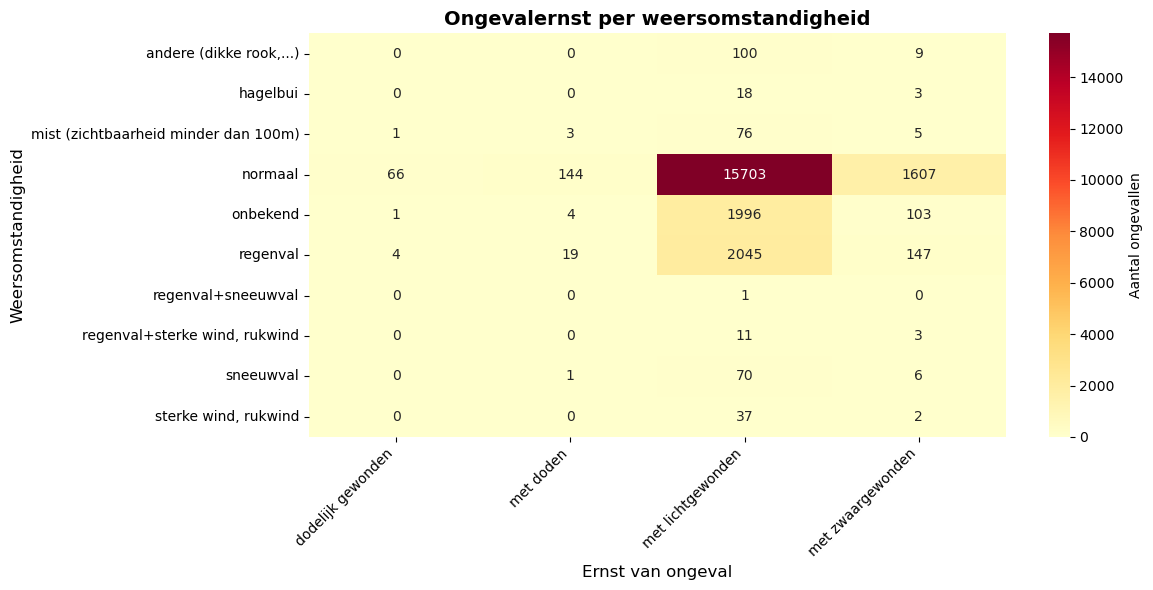

In [18]:
## Dataset 2
# 1. Aantal ongevallen per weeromstandigheid en ernst van ongeval ophalen
weer_ernst = geolocalisatie_df.groupBy('TX_WEATHER_NL', 'TX_CLASS_ACCIDENTS_NL') \
    .agg(count('*').alias('aantal')) \
    .orderBy('TX_WEATHER_NL', 'TX_CLASS_ACCIDENTS_NL') \
    .collect()

# 2. Unieke waarden ophalen
weercondities = sorted(list(set([row['TX_WEATHER_NL'] for row in weer_ernst])))
ernst_types = sorted(list(set([row['TX_CLASS_ACCIDENTS_NL'] for row in weer_ernst])))

# 3. Matrix maken
matrix = np.zeros((len(weercondities), len(ernst_types)))
for row in weer_ernst:
    i = weercondities.index(row['TX_WEATHER_NL'])
    j = ernst_types.index(row['TX_CLASS_ACCIDENTS_NL'])
    matrix[i, j] = row['aantal']

# 4. Heatmap - Stijl m.b.v. Claude
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=ernst_types, yticklabels=weercondities,
            cbar_kws={'label': 'Aantal ongevallen'})
plt.title('Ongevalernst per weersomstandigheid', fontsize=14, fontweight='bold')
plt.xlabel('Ernst van ongeval', fontsize=12)
plt.ylabel('Weersomstandigheid', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 5. Voertuig-specifieke analyses

#### a. Windsnelheid impact op motor- en bromfietsen

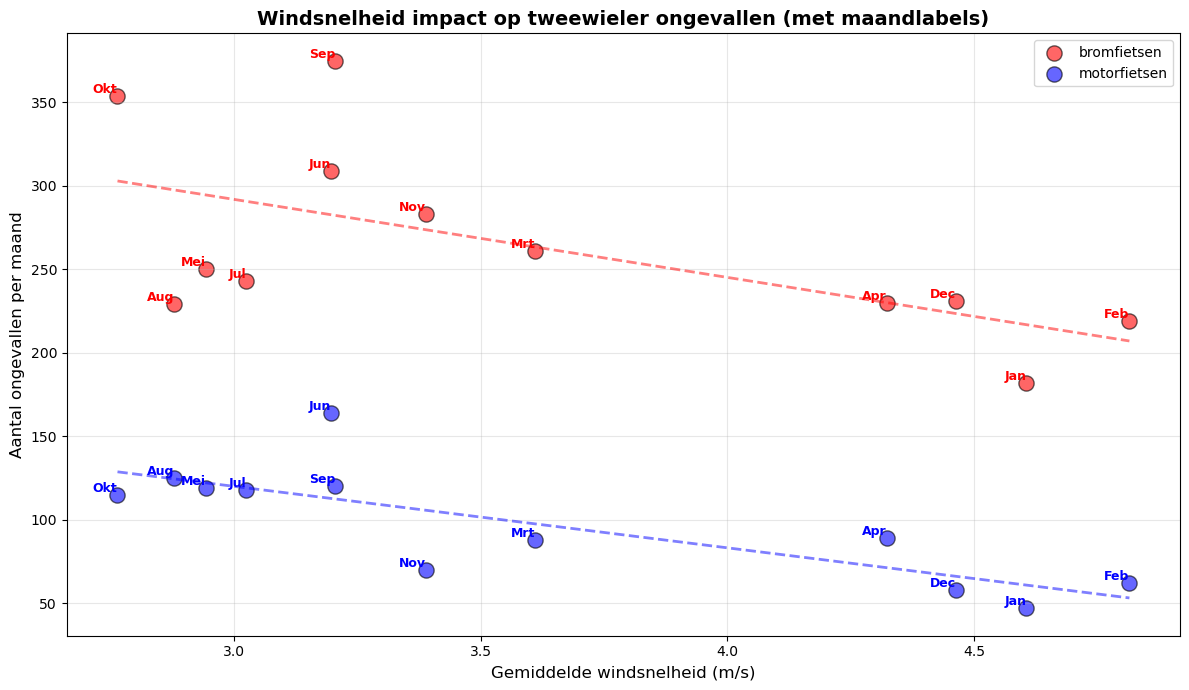

In [19]:
## Dataset 1 + 3
# 1. Selecteer alle tweewielers
tweewielers = ['motorfietsen', 'bromfietsen'] # Enige tweewielers die voorkomen in dataset

# 2. Ongevallen per maand voor tweewielers ophalen
tweewieler_ongeval = voertuig_df.filter(col('TX_VEHICLE_SEGMENT_A_NL').isin(tweewielers)) \
    .groupBy('DT_MONTH_COLLISION', 'TX_VEHICLE_SEGMENT_A_NL') \
    .agg(count('*').alias('aantal_ongevallen'))

# 3. Gemiddeld windsnelheid en -stoten per maand ophalen
wind_maand = weer_df.groupBy('maand') \
    .agg(avg('wind_speed_10m').alias('gem_windsnelheid'),
         avg('wind_gusts_speed').alias('gem_windstoten')) \
    .orderBy('maand')

# 4. Join per voertuigtype + collect
motor_wind = tweewieler_ongeval.join(wind_maand, tweewieler_ongeval.DT_MONTH_COLLISION == wind_maand.maand, 'inner') \
    .collect()

# 5. Organiseer data per voertuigtype
voertuig_data = {}
for row in motor_wind:
    voertuig = row['TX_VEHICLE_SEGMENT_A_NL']
    if voertuig not in voertuig_data:
        voertuig_data[voertuig] = {'wind': [], 'ongevallen': [], 'maand': []} 
    
    voertuig_data[voertuig]['wind'].append(row['gem_windsnelheid'])
    voertuig_data[voertuig]['ongevallen'].append(row['aantal_ongevallen'])
    voertuig_data[voertuig]['maand'].append(row['maand']) 

# 6. Plot - Stijl + labels m.b.v. Claude
fig, ax = plt.subplots(figsize=(12, 7))

colors_voertuig = ['red', 'blue']

# Mapping voor maandnamen (voor labels)
maand_namen = {1:'Jan', 2:'Feb', 3:'Mrt', 4:'Apr', 5:'Mei', 6:'Jun', 
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Okt', 11:'Nov', 12:'Dec'}

for i, (voertuig, data) in enumerate(voertuig_data.items()):
    ax.scatter(data['wind'], data['ongevallen'], 
               s=120, alpha=0.6, label=voertuig, 
               color=colors_voertuig[i % len(colors_voertuig)],
               edgecolors='black', linewidth=1)
    
    # Loop door de punten om tekst toe te voegen
    for x, y, m in zip(data['wind'], data['ongevallen'], data['maand']):
        label = maand_namen.get(m, str(m)) # Haal afkorting op
        ax.text(x, y, label, 
                fontsize=9, 
                ha='right', va='bottom', # Positie tekst t.o.v. bolletje
                color=colors_voertuig[i % len(colors_voertuig)],
                fontweight='bold') 
    
    # Trendlijn - m.b.v. Stack Overflow
    if len(data['wind']) > 1:
        z = np.polyfit(data['wind'], data['ongevallen'], 1)
        p = np.poly1d(z)
        wind_range = np.linspace(builtins.min(data['wind']), builtins.max(data['wind']), 50)
        ax.plot(wind_range, p(wind_range), '--', 
                color=colors_voertuig[i % len(colors_voertuig)], alpha=0.5, linewidth=2)
    
ax.set_xlabel('Gemiddelde windsnelheid (m/s)', fontsize=12)
ax.set_ylabel('Aantal ongevallen per maand', fontsize=12)
ax.set_title('Windsnelheid impact op tweewieler ongevallen (met maandlabels)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### b. Voertuigtype per wegtype

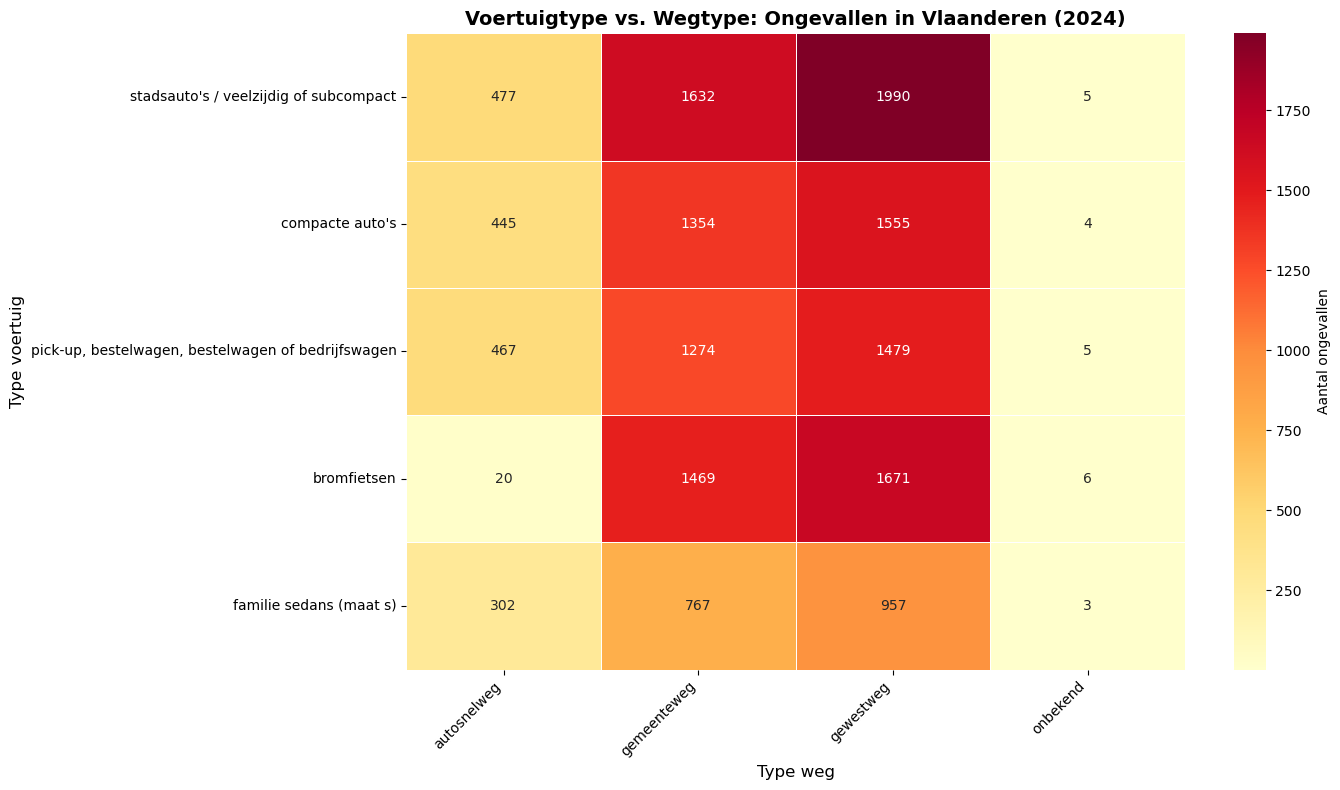

In [20]:
## Dataset 1
# 1. Filter nulls en selecteer top 5 voertuigen
top_voertuigen = voertuig_df.filter(col('TX_VEHICLE_SEGMENT_A_NL').isNotNull()) \
    .groupBy('TX_VEHICLE_SEGMENT_A_NL') \
    .agg(count('*').alias('totaal')) \
    .orderBy(col('totaal').desc()) \
    .limit(5) \
    .select('TX_VEHICLE_SEGMENT_A_NL') \
    .rdd.flatMap(lambda x: x) \
    .collect()

# 2. Filter op top voertuigen en groepeer per wegtype
voertuig_wegtype = voertuig_df.filter((col('TX_VEHICLE_SEGMENT_A_NL').isin(top_voertuigen)) & (col('TX_ROAD_TYPE_NL').isNotNull())) \
    .groupBy('TX_VEHICLE_SEGMENT_A_NL', 'TX_ROAD_TYPE_NL') \
    .agg(count('*').alias('aantal')) \
    .collect()

# 3. Organiseer data
wegtypes = sorted(list(set([row['TX_ROAD_TYPE_NL'] for row in voertuig_wegtype])))
voertuig_dict = {voertuig: [0] * len(wegtypes) for voertuig in top_voertuigen}

for row in voertuig_wegtype:
    voertuig = row['TX_VEHICLE_SEGMENT_A_NL']
    wegtype = row['TX_ROAD_TYPE_NL']
    if voertuig in voertuig_dict and wegtype in wegtypes:
        wegtype_idx = wegtypes.index(wegtype)
        voertuig_dict[voertuig][wegtype_idx] = row['aantal']

# 4. Matrix maken + plot - Stijl m.b.v. Claude
matrix_wegtype = np.zeros((len(top_voertuigen), len(wegtypes)))
for i, voertuig in enumerate(top_voertuigen):
    for j, wegtype in enumerate(wegtypes):
        matrix_wegtype[i, j] = voertuig_dict[voertuig][j]

plt.figure(figsize=(14, 8))
sns.heatmap(matrix_wegtype, annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=wegtypes, yticklabels=top_voertuigen,
            cbar_kws={'label': 'Aantal ongevallen'}, linewidths=0.5)
plt.title('Voertuigtype vs. Wegtype: Ongevallen in Vlaanderen (2024)', fontsize=14, fontweight='bold')
plt.xlabel('Type weg', fontsize=12)
plt.ylabel('Type voertuig', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### c. Eigenaarschap (bedrijfswagen vs particulier)

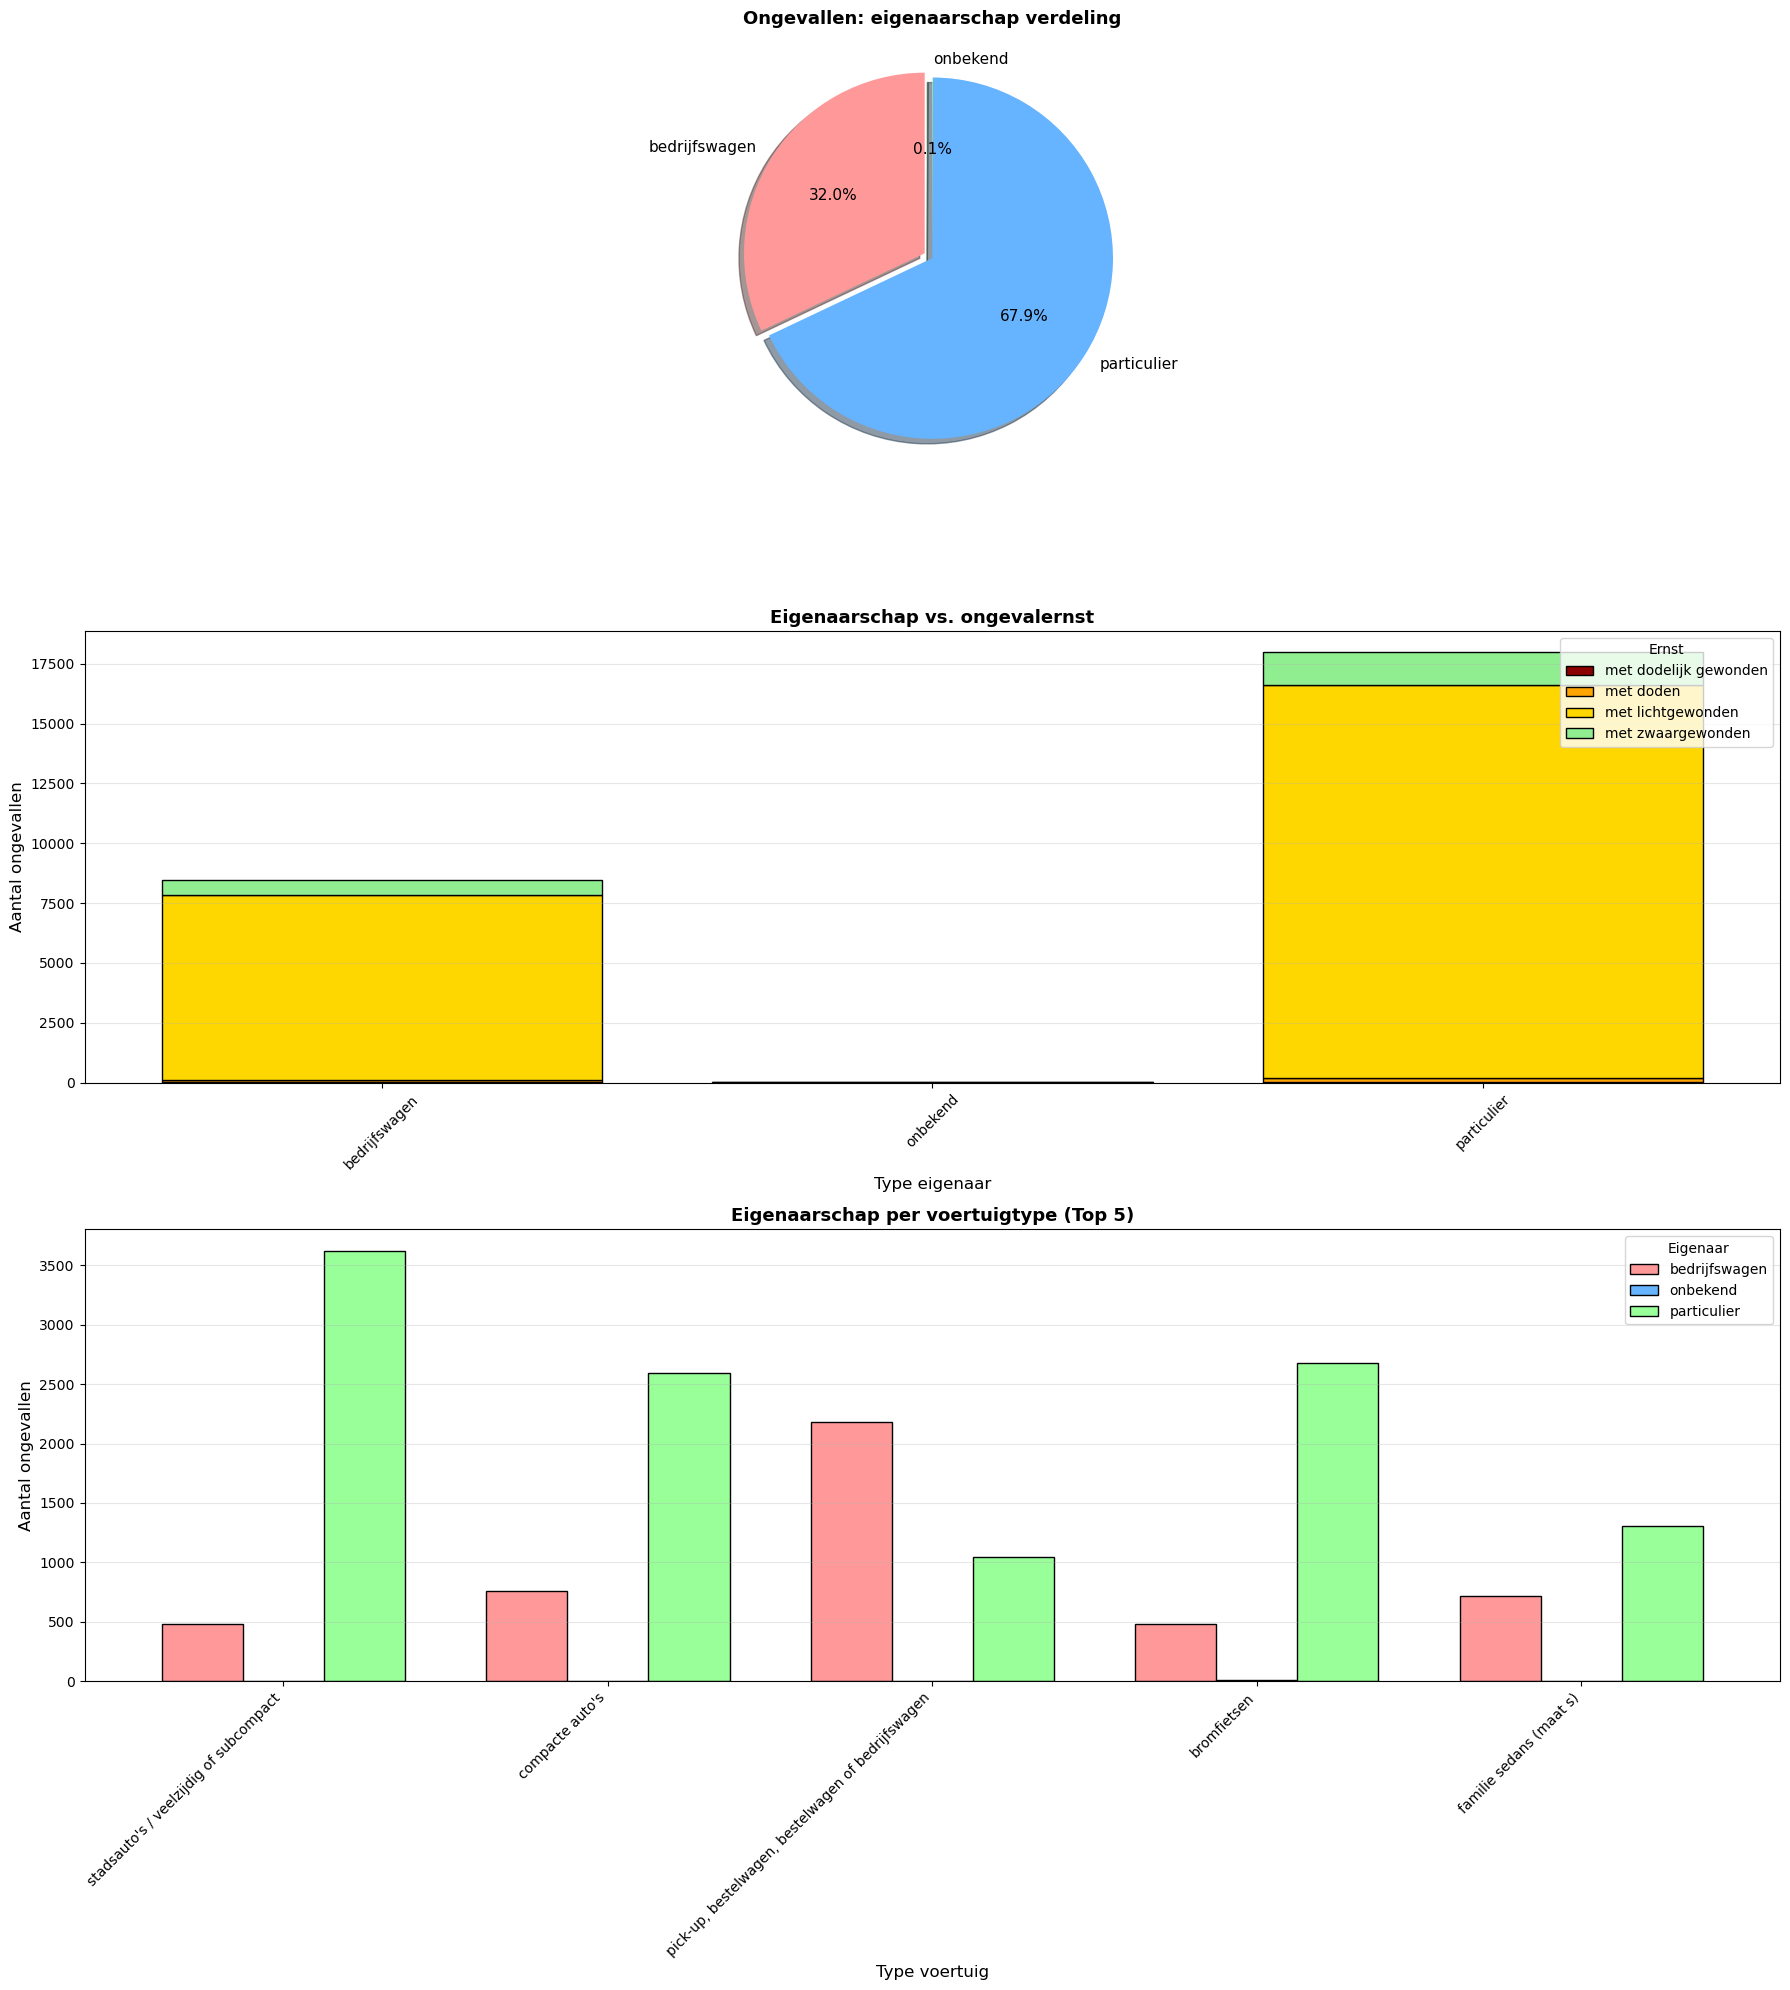

In [21]:
## Dataset 1
# 1. Filter nulls
eigenaar_totaal = voertuig_df.filter(col('TX_OWNER_TYPE_NL').isNotNull()) \
    .groupBy('TX_OWNER_TYPE_NL') \
    .agg(count('*').alias('totaal_ongevallen')) \
    .collect()

# 2. Haal data op voor plot
labels_eigenaar = [row['TX_OWNER_TYPE_NL'] for row in eigenaar_totaal]
sizes_eigenaar = [row['totaal_ongevallen'] for row in eigenaar_totaal]

# 3. Plots - M.b.v. Claude
colors_pie = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
fig, axes = plt.subplots(3, figsize=(18, 20))

    # Subplot 1
explode = [0.05 if i == 0 else 0 for i in range(len(labels_eigenaar))]
axes[0].pie(sizes_eigenaar, labels=labels_eigenaar, autopct='%1.1f%%',
            colors=colors_pie, startangle=90, explode=explode,
            textprops={'fontsize': 11}, shadow=True)
axes[0].set_title('Ongevallen: eigenaarschap verdeling', fontsize=13, fontweight='bold')

# 4. Eigenaarschap vs ernst
eigenaar_ernst = voertuig_df.filter((col('TX_OWNER_TYPE_NL').isNotNull()) & (col('TX_ACCIDENT_CLASS_NL').isNotNull())) \
    .groupBy('TX_OWNER_TYPE_NL', 'TX_ACCIDENT_CLASS_NL') \
    .agg(count('*').alias('aantal')) \
    .collect()

ernst_types = sorted(list(set([row['TX_ACCIDENT_CLASS_NL'] for row in eigenaar_ernst])))
eigenaar_types = sorted(list(set([row['TX_OWNER_TYPE_NL'] for row in eigenaar_ernst])))

# 5. Matrix maken
matrix_eigenaar = np.zeros((len(eigenaar_types), len(ernst_types)))
for row in eigenaar_ernst:
    i = eigenaar_types.index(row['TX_OWNER_TYPE_NL'])
    j = ernst_types.index(row['TX_ACCIDENT_CLASS_NL'])
    matrix_eigenaar[i, j] = row['aantal']

    # Subplot 2
bottom = np.zeros(len(eigenaar_types))
colors_ernst = ['darkred', 'orange', 'gold', 'lightgreen']

for j, ernst in enumerate(ernst_types):
    values = matrix_eigenaar[:, j]
    axes[1].bar(eigenaar_types, values, bottom=bottom, label=ernst,
                color=colors_ernst[j % len(colors_ernst)], edgecolor='black', linewidth=1)
    bottom += values

axes[1].set_xlabel('Type eigenaar', fontsize=12)
axes[1].set_ylabel('Aantal ongevallen', fontsize=12)
axes[1].set_title('Eigenaarschap vs. ongevalernst', fontsize=13, fontweight='bold')
axes[1].legend(title='Ernst', fontsize=10, loc='upper right')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# 6. Eigenaarschap vs voertuigtype
top_5_voertuigen = voertuig_df.filter(col('TX_VEHICLE_SEGMENT_A_NL').isNotNull()) \
    .groupBy('TX_VEHICLE_SEGMENT_A_NL') \
    .agg(count('*').alias('totaal')) \
    .orderBy(col('totaal').desc()) \
    .limit(5) \
    .select('TX_VEHICLE_SEGMENT_A_NL') \
    .rdd.flatMap(lambda x: x) \
    .collect()

eigenaar_voertuig = voertuig_df.filter(
    (col('TX_VEHICLE_SEGMENT_A_NL').isin(top_5_voertuigen)) &
    (col('TX_OWNER_TYPE_NL').isNotNull())) \
    .groupBy('TX_OWNER_TYPE_NL', 'TX_VEHICLE_SEGMENT_A_NL') \
    .agg(count('*').alias('aantal')) \
    .collect()

# 7. Organiseer data
voertuig_eigenaar_dict = {eigenaar: [0] * len(top_5_voertuigen) for eigenaar in eigenaar_types}
for row in eigenaar_voertuig:
    eigenaar = row['TX_OWNER_TYPE_NL']
    voertuig = row['TX_VEHICLE_SEGMENT_A_NL']
    if voertuig in top_5_voertuigen:
        voertuig_idx = top_5_voertuigen.index(voertuig)
        voertuig_eigenaar_dict[eigenaar][voertuig_idx] = row['aantal']

    # Subplot 3: Grouped bar
x3 = np.arange(len(top_5_voertuigen))
width = 0.25

for i, (eigenaar, aantallen) in enumerate(voertuig_eigenaar_dict.items()):
    offset = width * i - width * (len(eigenaar_types)-1) / 2
    axes[2].bar(x3 + offset, aantallen, width, label=eigenaar,
                color=colors_pie[i % len(colors_pie)], edgecolor='black', linewidth=1)

axes[2].set_xlabel('Type voertuig', fontsize=12)
axes[2].set_ylabel('Aantal ongevallen', fontsize=12)
axes[2].set_title('Eigenaarschap per voertuigtype (Top 5)', fontsize=13, fontweight='bold')
axes[2].set_xticks(x3)
axes[2].set_xticklabels(top_5_voertuigen, rotation=45, ha='right')
axes[2].legend(title='Eigenaar', fontsize=10)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## D. Conclusies

- **Locatie & tijd:** De meeste ongevallen gebeuren waar en wanneer het druk is: in dichtbevolkte steken (met een piek in Antwerpen), op weekdagen en tijdens de spits (7-9u en 16-18u). Stadsauto's op gewestwegen zijn het vaaksts betrokken.
- **Belangrijk te vermelden:** Uit deze cijfers mag men geen conclusies rond de veiligheid van het verkeer nemen. Volgens één van de grafieken gebeuren er minder ongevallen met tweewielers bij harde wind. Uiteraard komt dit doordat er wellicht minder tweewielers op de baan zijn. Verder gebeuren de meeste ongevallen overdag en bij gewoon weer (lees: geen regen, sterke wind, mist of sneeuw). De minste ongevallen doen zich in de nacht bij slecht weer voor. Dit komt omdat het verkeersvolume veel lager is en niet omdat de combinatie van sneeuw en donkerte veiliger is.